In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_coefficients_vertical_legend(group_name, group_df, color_map):
    if group_df.empty:
        print(f"No data available for group {group_name}. Skipping plot.")
        return None

    factors = group_df['new_name'].dropna().unique()
    x_positions = np.arange(len(factors))
    models = group_df['model'].unique()
    bar_width = 0.8 / len(models)

    fig = plt.figure(figsize=(12, 6))
    for i, model in enumerate(models):
        model_data = group_df[group_df['model'] == model]
        aligned_data = model_data.set_index('new_name').reindex(factors).reset_index()
        positions = x_positions + i * bar_width
        coeffs = aligned_data['Coef.']
        ci_low = aligned_data['ci_low']
        ci_high = aligned_data['ci_high']

        bar_style = {"color": 'dimgray', "hatch": '//', "alpha": 0.8, "edgecolor": 'black'} if model == "human" else {"color": color_map.get(model, 'blue'), "alpha": 0.8, "edgecolor": 'black'}
        error_color = 'black'

        plt.bar(positions, coeffs, bar_width, label=model, **bar_style)
        plt.errorbar(positions, coeffs, yerr=[coeffs - ci_low, ci_high - coeffs], fmt='none',
                     ecolor=error_color, capsize=3, alpha=0.8)

    plt.xticks(x_positions + bar_width * (len(models) - 1) / 2, factors, rotation=45, ha='right')
    plt.ylabel('Regression Coefficients')
    plt.title(f'Regression Coefficients by {group_name}')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.legend(title="Model", loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
    plt.tight_layout()
    
    return fig

def main(coefficients_path, new_names_path):
    coefficients = pd.read_csv(coefficients_path)
    new_names = pd.read_csv(new_names_path)
    coefficients = coefficients.merge(new_names, left_on='Unnamed: 0', right_on='Original_name', how='left')
    coefficients.rename(columns={'[0.025': 'ci_low', '0.975]': 'ci_high'}, inplace=True)
    coefficients['significant'] = coefficients['P>|t|'] < 0.05

    missing_name_mapping = {
        "C(age, Treatment(reference=25))[T.5]": "Age 5",
        "C(age, Treatment(reference=25))[T.10]": "Age 10",
        "C(age, Treatment(reference=25))[T.14]": "Age 14",
        "C(age, Treatment(reference=25))[T.16]": "Age 16",
        "C(age, Treatment(reference=25))[T.20]": "Age 20",
        "C(age, Treatment(reference=25))[T.50]": "Age 50",
        "C(age, Treatment(reference=25))[T.80]": "Age 80",
        "C(hours_missing, Treatment(reference=8))[T.10]": "Hours Missing 10",
        "C(hours_missing, Treatment(reference=8))[T.14]": "Hours Missing 14",
        "C(hours_missing, Treatment(reference=8))[T.18]": "Hours Missing 18",
        "C(ethnicity, Treatment(reference='White'))[T.Asian]": "Ethnicity: Asian",
        "C(ethnicity, Treatment(reference='White'))[T.Black]": "Ethnicity: Black",
        "C(ethnicity, Treatment(reference='White'))[T.mixed race]": "Ethnicity: Mixed Race"
    }
    coefficients['new_name'] = coefficients['new_name'].fillna(
        coefficients['Original_name'].map(missing_name_mapping)
    )

    grouped_coefficients = coefficients.groupby('Group')
    unique_models = coefficients['model'].unique()
    color_map = {model: plt.cm.tab10(i % 10) for i, model in enumerate(unique_models)}

    plots_dict = {}
    for group_name, group_df in grouped_coefficients:
        plot = plot_coefficients_vertical_legend(group_name, group_df, color_map)
        if plot:
            plots_dict[group_name] = plot
            plt.close(plot)  # Close the figure to free memory
    
    return plots_dict


coefficients_path = "data/copbot_coefficients.csv"  # Replace with your file path
new_names_path = "data/copbot_new_names.csv"    

coefficient_plots = main(coefficients_path, new_names_path)
coefficient_plots


/home/andreas/Documents/Projects/copbot-analysis/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/andreas/Documents/Projects/copbot-analysis/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/andreas/Documents/Projects/copbot-analysis/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/andreas/Documents/Projects/copbot-analysis/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single elemen

{'Age (25 as reference category)': <Figure size 1200x600 with 1 Axes>,
 'Ethnicity (white as reference category)': <Figure size 1200x600 with 1 Axes>,
 'Hours missing (8 as reference category)': <Figure size 1200x600 with 1 Axes>,
 'Intercept': <Figure size 1200x600 with 1 Axes>,
 'Risk Factor (out of character as reference category)': <Figure size 1200x600 with 1 Axes>,
 'Sex (female as reference category)': <Figure size 1200x600 with 1 Axes>}

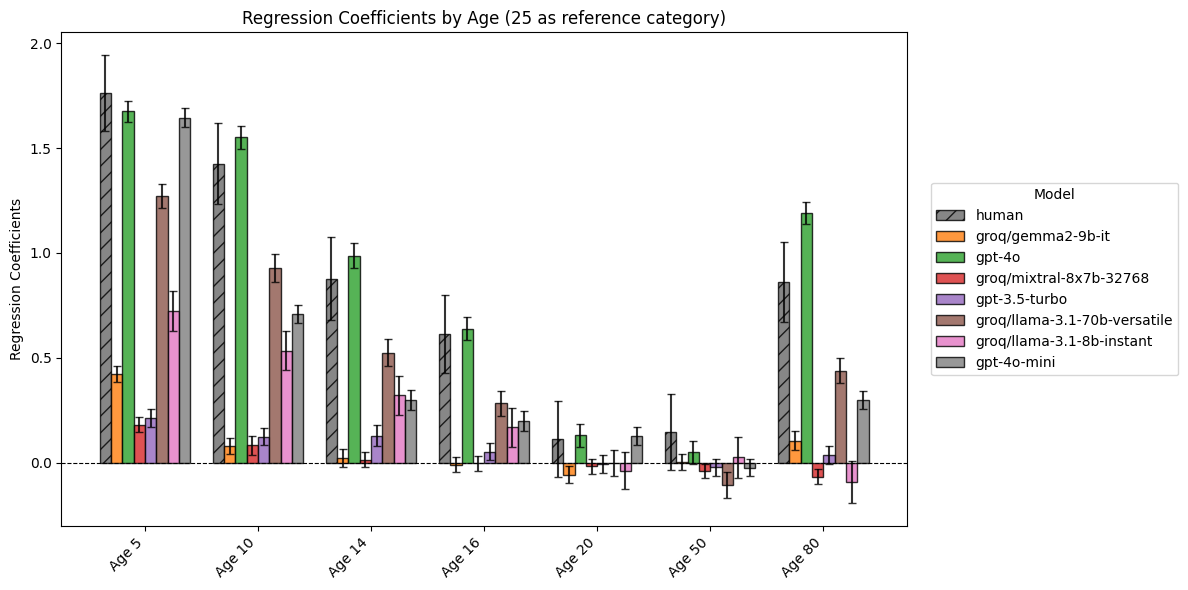

In [17]:
coefficient_plots['Age (25 as reference category)']

In [12]:
import pandas as pd
import numpy as np

# Load the CSV file
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Process the data to calculate metrics
def calculate_metrics(data):
    # Filter out human predictions as the baseline
    human_predictions = data[data['model'] == 'human'][['id', 'predicted_risk']]
    human_predictions.rename(columns={'predicted_risk': 'human_risk'}, inplace=True)

    # Merge human predictions into the main dataset
    merged_data = data.merge(human_predictions, on='id', how='left')

    # Calculate errors
    merged_data['error'] = merged_data['predicted_risk'] - merged_data['human_risk']
    merged_data['absolute_error'] = merged_data['error'].abs()

    # Group by model to calculate metrics
    model_metrics = merged_data.groupby('model').agg({
        'error': ['mean', 'var'],
        'absolute_error': 'mean',
        'predicted_risk': lambda x: np.sqrt(np.mean((x - merged_data.loc[x.index, 'human_risk']) ** 2))
    }).reset_index()

    # Rename columns for clarity
    model_metrics.columns = ['model', 'mean_error', 'variance_error', 'mean_absolute_error', 'rmse']
    return model_metrics

# Main function to process the file and return a dataframe
def main(file_path):
    data = load_data(file_path)

    # Rename specific models
    data['model'] = data['model'].replace({
        'groq/mixtral-8x7b-32768': 'mixtral-8x7b',
        'groq/llama-3.1-8b-instant': 'llama-3.1-8b'
    })

    # Calculate and return metrics as a dataframe
    return calculate_metrics(data)

file_path = 'data/results.csv'
metrics_df = main(file_path)
metrics_df['model'] = metrics_df['model'].str.replace('groq/', '')
metrics_df.columns = ['model', 'Mean Error', 'Variance of Error', 'Mean Absolute Error', 'RMSE']
metrics_df.drop(5).set_index('model').sort_values('RMSE')


,Mean Error,Variance of Error,Mean Absolute Error,RMSE
model,,,,
llama-3.1-70b-versatile,-0.029617,0.502977,0.561255,0.709710
gpt-4o-mini,-0.026508,0.571514,0.566625,0.756354
gpt-4o,0.345557,0.546063,0.588107,0.815683
llama-3.1-8b,-0.245174,0.793188,0.732015,0.923606
gemma2-9b-it,-0.423032,0.742196,0.779581,0.959662
gpt-3.5-turbo,0.007275,0.965954,0.812442,0.982739
mixtral-8x7b,-0.697935,0.724766,0.878256,1.100761
